  The MDSplus python module version ((7, 153, 3)) does not match
  the version of the installed MDSplus libraries (Unknown).
  Upgrade the module using the mdsplus/python/MDSplus directory of the
  MDSplus installation or set PYTHONPATH=/usr/local/mdsplus/python/MDSplus.


data length: 102400 pts


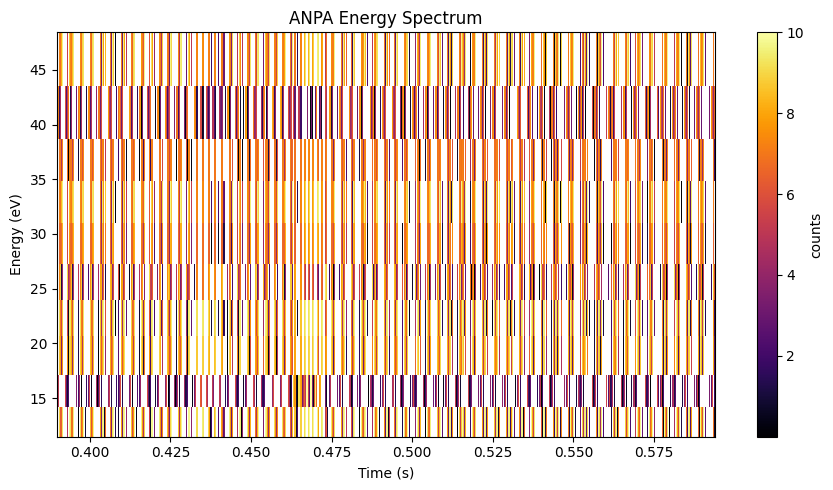

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import importlib.util

# matplotlib.use('TkAgg')  # commented out - not needed in Jupyter notebooks
clrs = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Import MDSplus for data acquisition
spec = importlib.util.spec_from_file_location("MDSplus", "/p/ltxdata/bin/MDSplus/__init__.py")
MDSplus = importlib.util.module_from_spec(spec)
spec.loader.exec_module(MDSplus)


def get_anpa_rawdata(shot, npt=None, cal=False):
    """
    Load CHRONOS inputs 51-60 from MDSplus (wire calorimeter data).

    Parameters
    ----------
    shot : int
        Shot number to load
    npt : int, optional
        Number of time points to load from each channel
    cal : bool, optional
        If True, apply relative calibration factors

    Returns
    -------
    anpa : ndarray, shape (10, npt)
        Raw detector waveforms for CHRONOS inputs 51-60
    t_anpa : ndarray, shape (npt)
        Time array

    Notes
    -----
    Loads CHRONOS digitizer inputs 51-60 instead of ANPA detector channels.
    """

    rel_cal = [0.315, 0.389, 0.56, 1.000, 0.955, 1.177, 1.212, 1.065, 1.106, 0.502]  # calibration factors

    # Connect to MDSplus server
    conn = MDSplus.Connection('lithos.pppl.gov:8000')
    conn.openTree('ltx_b', shot)
    
    # Get first channel to determine data length
    first_node = r'\ltx_b::top.devices.dtacq.chronos:input_51'
    if npt is None:
        npt = len(conn.get(first_node).data())
    print(f'data length: {npt} pts')
    
    anpa = np.zeros((10, npt), dtype=float)

    # --- Load CHRONOS channels (input_51 ... input_60)
    for i in range(10):
        node = rf'\ltx_b::top.devices.dtacq.chronos:input_{51 + i:02d}'
        sig = conn.get(node).data()
        anpa[i, :] = sig[:npt]
    
    # Get time dimension from first channel
    t_anpa = conn.get(f'dim_of({first_node})').data()
    
    conn.closeAllTrees()

    if cal:
        for i in np.arange(10):
            anpa[i, :] /= rel_cal[i]

    return anpa, t_anpa


# Optional: place-holder to add bias compensation later
def apply_bias_compensation(anpa, bias_voltages, calibration_curve):
    """
    Placeholder for bias compensation logic.

    Parameters
    ----------
    anpa : ndarray
        Raw detector data (output of get_anpa_rawdata)
    bias_voltages : array-like, length 20
        Bias voltage applied to each detector during the shot
    calibration_curve : callable or lookup table
        Function G(V) mapping bias voltage to detector gain

    Returns
    -------
    corrected : ndarray
        Bias-corrected detector signals

    Notes
    -----
    You will replace this once you locate your gain calibration function.
    """
    # Example: match all detectors to a reference bias V_ref
    V_ref = np.mean(bias_voltages)

    gain_factors = calibration_curve(V_ref) / calibration_curve(np.array(bias_voltages))[:, None]
    return anpa * gain_factors


def energy_calibration():
    """
    :return:
      energy: peaked energy for each channel (keV)
      low_energy: lower limit of energy for each channel (keV)
      high_energy: upper limit of energy for each channel (keV)
    """
    energy = np.array([11.48, 14.17, 17.11, 20.69, 23.93, 27.23, 30.96, 34.82, 38.70, 43.56])  # H
    three_sigma = np.array([1.85, 2.62, 3.61, 4.73, 5.05, 5.29, 5.61, 5.89, 5.98, 6.92])  # H only
    low_energy = energy - three_sigma
    high_energy = energy + three_sigma
    return energy, low_energy, high_energy


def apply_filter(anpa):
    # optional place to apply Savortsky filter or whatever
    return anpa


def plot_anpa_rawdata(shot, logscale=False, cmap='inferno'):
    anpa, t_anpa = get_anpa_rawdata(shot)  # anpa shape = [10 channels, time]
    anpa = apply_filter(anpa)
    energy, low_energy, high_energy = energy_calibration()

    # todo: need to digitize target, lens, capacitor, and detector voltages!
    v_target = 0.  # foil voltage (for shifting energy sensitivity range)
    energy = energy - v_target
    # low_energy = low_energy - v_target
    # high_energy = high_energy - v_target

    Z = np.where(anpa>0, anpa, np.nan)
    if logscale:
        Z = np.log10(Z)

    plt.figure(figsize=(9,5))
    t_edges = np.concatenate([t_anpa, [t_anpa[-1] + (t_anpa[-1]-t_anpa[-2])]])
    e_edges = np.concatenate([energy, [energy[-1] + (energy[-1]-energy[-2])]])

    plt.pcolormesh(t_edges, e_edges, Z, shading='auto', cmap=cmap)
    plt.xlabel("Time (s)")
    plt.ylabel("Energy (eV)")
    plt.title("ANPA Energy Spectrum")
    cb = plt.colorbar()
    cb.set_label("log10(counts)" if logscale else "counts")
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    plot_anpa_rawdata(112483)
